In [1]:
!pip install dlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 44.2 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for dlib: filename=dlib-19.24.4-cp310-cp310-linux_x86_64.whl size=3327200 sha256=55a48b0ed8ebf5593771bb9116608f952b457e8232c7517af08db56ba1e04b3e
  Stored in directory: /root/.cache/pip/wheels/08/5e/55/a7db8d57920eb2c2aa41c36dc4c6d3cd12323865de191a7211
Successfully built dlib


In [2]:
!pip install requests
import requests

def download_file(url, filename):
    # Send a GET request to the URL
    response = requests.get(url)
    response.raise_for_status()  # Raises an exception for HTTP errors
    
    # Save the file
    with open(filename, 'wb') as f:
        f.write(response.content)
    print(f'Download complete: {filename}')

# URL to the dlib pre-trained model for facial landmark detection
url = "https://github.com/davisking/dlib-models/raw/master/shape_predictor_68_face_landmarks.dat.bz2"
filename = "shape_predictor_68_face_landmarks.dat.bz2"

download_file(url, filename)

print("Unzipping the file...")

# Unzipping the .bz2 file to get the .dat file
import bz2
with bz2.open(filename, 'rb') as file:
    decompressed_data = file.read()
    with open('shape_predictor_68_face_landmarks.dat', 'wb') as new_file:
        new_file.write(decompressed_data)

print("File is ready to use: shape_predictor_68_face_landmarks.dat")

Download complete: shape_predictor_68_face_landmarks.dat.bz2
Unzipping the file...
File is ready to use: shape_predictor_68_face_landmarks.dat


In [4]:
import cv2
import dlib
import os
import numpy as np
import librosa
from transformers import BertTokenizer, BertModel

# Initialize face detector and shape predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Function to process text using BERT and get embeddings
def get_bert_embeddings(text):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=128)
    outputs = bert_model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().detach().numpy()
    return embeddings

# Function to process audio and get MFCC features
def get_mfcc_features(audio_path):
    y, sr = librosa.load(audio_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfcc_mean = np.mean(mfcc, axis=1)
    return mfcc_mean

# Function to process video and get facial landmarks for each frame
def process_video(video_path):
    cap = cv2.VideoCapture(video_path)
    frame_landmarks = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = detector(gray)
        
        for face in faces:
            shape = predictor(gray, face)
            landmark = np.array([(part.x, part.y) for part in shape.parts()]).flatten()
            frame_landmarks.append(landmark)
    
    cap.release()
    return frame_landmarks

# Function to read data from files and combine features
def read_data_from_files(main_directory_text, main_directory_audio, main_directory_video):
    data = []
    
    for class_folder in os.listdir(main_directory_text):
        class_folder_path_text = os.path.join(main_directory_text, class_folder)
        class_folder_path_audio = os.path.join(main_directory_audio, class_folder)
        class_folder_path_video = os.path.join(main_directory_video, class_folder)
        
        if os.path.isdir(class_folder_path_text) and os.path.isdir(class_folder_path_audio) and os.path.isdir(class_folder_path_video):
            text_files = {f[:-4]: f for f in os.listdir(class_folder_path_text) if f.endswith('.txt')}
            audio_files = {f[:-4]: f for f in os.listdir(class_folder_path_audio) if f.endswith('.wav')}
            video_files = {f[:-4]: f for f in os.listdir(class_folder_path_video) if f.endswith('.mp4')}
            
            common_files = set(text_files.keys()).intersection(audio_files.keys()).intersection(video_files.keys())
            
            for base_name in common_files:
                filepath_text = os.path.join(class_folder_path_text, text_files[base_name])
                filepath_audio = os.path.join(class_folder_path_audio, audio_files[base_name])
                filepath_video = os.path.join(class_folder_path_video, video_files[base_name])
                print(base_name)
                
                with open(filepath_text, 'r', encoding='utf-8') as file:
                    text = file.read()
                    text_embedding = get_bert_embeddings(text)
                
                mfcc_features = get_mfcc_features(filepath_audio)
                frame_landmarks = process_video(filepath_video)
                
                for landmark in frame_landmarks:
                    if landmark.size > 0:
                        combined_features = np.concatenate([text_embedding, mfcc_features, landmark])
                        data.append((combined_features, class_folder))
                    else:
                        print(f"No landmarks found for frame in video {base_name}, skipping.")
    
    return data

# Example usage
data_directory_text = '/kaggle/input/real-life-deception-detection/Transcription'
data_directory_audio = '/kaggle/input/real-life-deception-audio/Audio'
data_directory_video = '/kaggle/input/real-life-deception-detection/Real-life_Deception_Detection_2016/Clips'
data = read_data_from_files(data_directory_text, data_directory_audio, data_directory_video)

# Separate features and labels
features = np.array([d[0] for d in data])
labels = np.array([d[1] for d in data])

print("Features shape:", features.shape)
print("Labels shape:", labels.shape)


trial_lie_021
trial_lie_034
trial_lie_059
trial_lie_005
trial_lie_044
trial_lie_025
trial_lie_008
trial_lie_029
trial_lie_030
trial_lie_061
trial_lie_028
trial_lie_027
trial_lie_037
trial_lie_058
trial_lie_006
trial_lie_019
trial_lie_050
trial_lie_014
trial_lie_020
trial_lie_055
trial_lie_009
trial_lie_051
trial_lie_015
trial_lie_047
trial_lie_026
trial_lie_056
trial_lie_053
trial_lie_046
trial_lie_011
trial_lie_033
trial_lie_060
trial_lie_024
trial_lie_041
trial_lie_018
trial_lie_043
trial_lie_007
trial_lie_040
trial_lie_003
trial_lie_049
trial_lie_045
trial_lie_038
trial_lie_052
trial_lie_035
trial_lie_016
trial_lie_012
trial_lie_022
trial_lie_032
trial_lie_017
trial_lie_010
trial_lie_042
trial_lie_039
trial_lie_013
trial_lie_001
trial_lie_023
trial_lie_004
trial_lie_002
trial_lie_057
trial_lie_036
trial_lie_048
trial_lie_031
trial_lie_054
trial_truth_001
trial_truth_021
trial_truth_045
trial_truth_035
trial_truth_058
trial_truth_007
trial_truth_010
trial_truth_048
trial_truth_009
tr

In [5]:
import pickle

print("Features shape:", features.shape)
print("Labels shape:", labels.shape)

with open('V+A+T.pkl', 'wb') as file:
    pickle.dump((features, labels), file)

print("Data saved to data.pkl")

Features shape: (82575, 917)
Labels shape: (82575,)
Data saved to data.pkl


In [46]:
import pickle

with open('V+A+T.pkl', 'rb') as file:
    features, labels = pickle.load(file)

print("Features shape:", features.shape)
print("Labels shape:", labels.shape)

Features shape: (82575, 917)
Labels shape: (82575,)


In [47]:
import pandas as pd

features_df = pd.DataFrame(features)
features_df['label'] = labels

print(features_df)

              0         1         2         3         4         5         6  \
0      0.056180  0.388816  0.087349  0.000683  0.078985 -0.013532  0.010795   
1      0.056180  0.388816  0.087349  0.000683  0.078985 -0.013532  0.010795   
2      0.056180  0.388816  0.087349  0.000683  0.078985 -0.013532  0.010795   
3      0.056180  0.388816  0.087349  0.000683  0.078985 -0.013532  0.010795   
4      0.056180  0.388816  0.087349  0.000683  0.078985 -0.013532  0.010795   
...         ...       ...       ...       ...       ...       ...       ...   
82570  0.086598 -0.145624  0.095630  0.293670  0.370618 -0.001480 -0.010124   
82571  0.086598 -0.145624  0.095630  0.293670  0.370618 -0.001480 -0.010124   
82572  0.086598 -0.145624  0.095630  0.293670  0.370618 -0.001480 -0.010124   
82573  0.086598 -0.145624  0.095630  0.293670  0.370618 -0.001480 -0.010124   
82574  0.086598 -0.145624  0.095630  0.293670  0.370618 -0.001480 -0.010124   

              7         8         9  ...    908    

In [48]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(features_df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42)

In [49]:
print(train_df.shape)
print(test_df.shape)
print(val_df.shape)

(49545, 918)
(16515, 918)
(16515, 918)


In [50]:
def separate_features_and_labels(df):
    X = df.drop(columns=['label']).values  # Drop the label column to get features
    y = df['label'].apply(lambda x: 1 if x == 'Truthful' else 0).values  # Convert labels to binary
    return X, y

X_train, y_train = separate_features_and_labels(train_df)
X_val, y_val = separate_features_and_labels(val_df)
X_test, y_test = separate_features_and_labels(test_df)

In [51]:
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [55]:
import tensorflow as tf
from tensorflow.keras import layers, models

input_shape = (X_train.shape[1], X_train.shape[2])  # (timesteps, features)
model = models.Sequential([
    layers.LSTM(1024, input_shape=input_shape, return_sequences=True),
    layers.Dropout(0.2),
    layers.LSTM(512, return_sequences=True),
    layers.Dropout(0.2),
    layers.LSTM(256, return_sequences=False),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

learning_rate = 0.00001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_33 (LSTM)                  │ (None, 1, 1024)        │     7,954,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 1, 1024)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_34 (LSTM)                  │ (None, 1, 512)         │     3,147,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 1, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_35 (LSTM)                  │ (None, 256)            │       787,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,889,921 (45.36 MB)

 Trainable params: 11,889,921 (45.36 MB)

 Non-trainable params: 0 (0.00 B)

In [56]:
batch_size = 128
epochs = 20

history = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val, y_val))

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Loss: {test_loss:.4f}')

Epoch 1/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.7417 - loss: 0.6495 - val_accuracy: 0.8228 - val_loss: 0.4092
Epoch 2/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8501 - loss: 0.3539 - val_accuracy: 0.9183 - val_loss: 0.1988
Epoch 3/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9168 - loss: 0.2002 - val_accuracy: 0.9393 - val_loss: 0.1416
Epoch 4/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9297 - loss: 0.1607 - val_accuracy: 0.9502 - val_loss: 0.1216
Epoch 5/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9414 - loss: 0.1330 - val_accuracy: 0.9628 - val_loss: 0.0929
Epoch 6/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9453 - loss: 0.1202 - val_accuracy: 0.9751 - val_loss: 0.0887
Epoch 7/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9473 - loss: 0.1135 - val_accuracy: 0.9736 - val_loss: 0.0773
Epoch 8/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9505 - loss: 0.1072 - val_accu

517/517 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9958 - loss: 0.0117
Test Accuracy: 0.995882511138916
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Confusion Matrix:
[[8497    5]
 [  63 7950]]


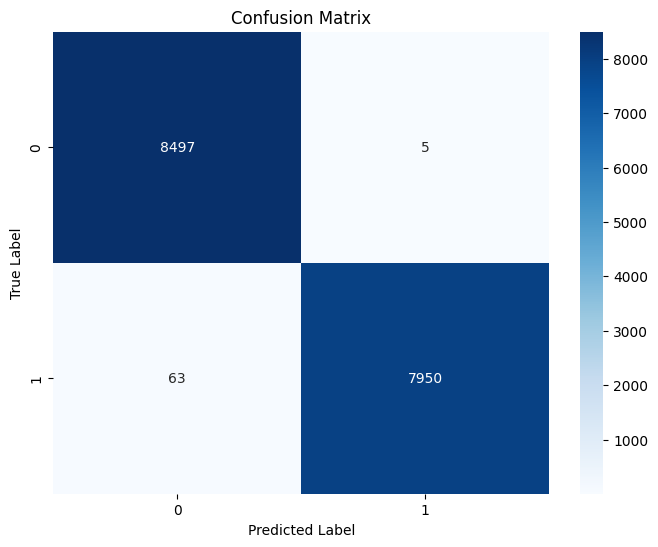

In [58]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")

# Predict probabilities
test_probabilities = model.predict(X_test)
# Convert probabilities to binary predictions (0 or 1)
test_predictions = (test_probabilities > 0.5).astype(int)

from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
# Fit the encoder with the original test labels to get the class names
encoder.fit(y_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, test_predictions)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Plot a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [57]:
model.save("V+A+T__99%dlibLSTM.h5")

In [59]:
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from keras.layers import LSTM, Bidirectional


input_shape = (X_train.shape[1], X_train.shape[2])
model = models.Sequential([
    layers.Bidirectional(LSTM(1024, return_sequences=True), input_shape=input_shape),
    layers.Dropout(0.2),
    layers.Bidirectional(LSTM(512, return_sequences=True)),
    layers.Dropout(0.2),
    layers.Bidirectional(LSTM(256, return_sequences=False)),
    layers.Dense(1, activation='sigmoid'),
                         ])

learning_rate = 0.00001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_3 (Bidirectional) │ (None, 1, 2048)        │    15,908,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 1, 2048)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 1, 1024)        │    10,489,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 1, 1024)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 512)            │     2,623,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,022,721 (110.71 MB)

 Trainable params: 29,022,721 (110.71 MB)

 Non-trainable params: 0 (0.00 B)

In [60]:
batch_size = 128
epochs = 20

history = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val, y_val))

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Loss: {test_loss:.4f}')

Epoch 1/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.7629 - loss: 0.5769 - val_accuracy: 0.8948 - val_loss: 0.2315
Epoch 2/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.9096 - loss: 0.2111 - val_accuracy: 0.9436 - val_loss: 0.1271
Epoch 3/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.9355 - loss: 0.1423 - val_accuracy: 0.9596 - val_loss: 0.0982
Epoch 4/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.9478 - loss: 0.1168 - val_accuracy: 0.9640 - val_loss: 0.0772
Epoch 5/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.9490 - loss: 0.1113 - val_accuracy: 0.9715 - val_loss: 0.0697
Epoch 6/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.9597 - loss: 0.0919 - val_accuracy: 0.9849 - val_loss: 0.0480
Epoch 7/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.9669 - loss: 0.0772 - val_accuracy: 0.9906 - val_loss: 0.0385
Epoch 8/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.9727 - loss: 0.0671 - val_acc

517/517 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9993 - loss: 0.0051
Test Accuracy: 0.999333918094635
517/517 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
Confusion Matrix:
[[8495    7]
 [   4 8009]]


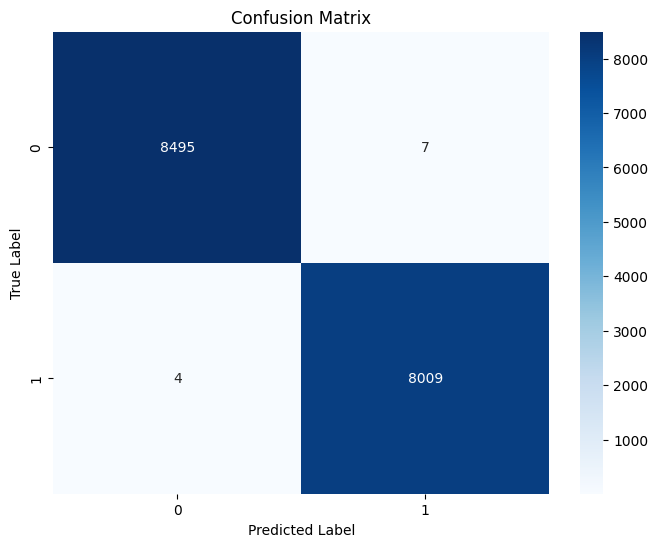

In [61]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")

# Predict probabilities
test_probabilities = model.predict(X_test)
# Convert probabilities to binary predictions (0 or 1)
test_predictions = (test_probabilities > 0.5).astype(int)

from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
# Fit the encoder with the original test labels to get the class names
encoder.fit(y_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, test_predictions)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Plot a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [62]:
model.save("V+A+T 99.9%bilstm dlib bert mfcc.h5")

In [63]:
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
import numpy as np
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, Concatenate


# Define the LSTM model
timesteps = 1
input_shape = (X_train.shape[1], X_train.shape[2])

input_layer = Input(shape=input_shape)

lstm1 = LSTM(1024, return_sequences=True)(input_layer)
lstm1 = Dropout(0.2)(lstm1)
lstm1 = LSTM(1024, return_sequences=True)(lstm1)
lstm1 = Dropout(0.2)(lstm1)
lstm2 = LSTM(512, return_sequences=True)(lstm1)
lstm2 = Dropout(0.2)(lstm2)

lstm3 = LSTM(1024, return_sequences=True)(lstm2)
lstm3 = Dropout(0.2)(lstm3)
lstm4 = LSTM(1024, return_sequences=True)(lstm3)
lstm4 = Dropout(0.2)(lstm4)
lstm5 = LSTM(512, return_sequences=True)(lstm4)
lstm5 = Dropout(0.2)(lstm5)

xor_layer = Dense(512, activation='relu')(lstm5)

concatenated = Concatenate()([lstm2, xor_layer])

lstm6 = LSTM(1024, return_sequences=True)(concatenated)
lstm6 = Dropout(0.2)(lstm6)
lstm6 = LSTM(512, return_sequences=True)(lstm6)
lstm6 = Dropout(0.2)(lstm6)
lstm7 = LSTM(256, return_sequences=True)(lstm6)
lstm7 = Dropout(0.2)(lstm7)

output_layer = Dense(1, activation='sigmoid')(lstm7[:, -1, :])

model = Model(inputs=input_layer, outputs=output_layer)

initial_learning_rate = 0.00001
opt = Adam(learning_rate=initial_learning_rate)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 1, 917)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_39 (LSTM)      │ (None, 1, 1024)   │  7,954,432 │ input_layer_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_37          │ (None, 1, 1024)   │          0 │ lstm_39[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_40 (LSTM)      │ (None, 1, 1024)   │  8,392,704 │ dropout_37[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_38          │ (None, 1, 1024)   │          0 │ lstm_40[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_41 (LSTM)      │ (None, 1, 512)    │  3,147,776 │ dropout_38[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_39          │ (None, 1, 512)    │          0 │ lstm_41[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_42 (LSTM)      │ (None, 1, 1024)   │  6,295,552 │ dropout_39[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_40          │ (None, 1, 1024)   │          0 │ lstm_42[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_43 (LSTM)      │ (None, 1, 1024)   │  8,392,704 │ dropout_40[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_41          │ (None, 1, 1024)   │          0 │ lstm_43[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_44 (LSTM)      │ (None, 1, 512)    │  3,147,776 │ dropout_41[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_42          │ (None, 1, 512)    │          0 │ lstm_44[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 1, 512)    │    262,656 │ dropout_42[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 1, 1024)   │          0 │ dropout_39[0][0], │
│ (Concatenate)       │                   │            │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_45 (LSTM)      │ (None, 1, 1024)   │  8,392,704 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_43          │ (None, 1, 1024)   │          0 │ lstm_45[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_46 (LSTM)      │ (None, 1, 512)    │  3,147,776 │ dropout_43[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_44          │ (None, 1, 512)    │          0 │ lstm_46[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_47 (LSTM)      │ (None, 1, 256)    │    787,456 │ dropout_44[0][0]

 Total params: 49,921,793 (190.44 MB)

 Trainable params: 49,921,793 (190.44 MB)

 Non-trainable params: 0 (0.00 B)

In [64]:
batch_size = 128
epochs = 20

history = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val, y_val))

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Loss: {test_loss:.4f}')

Epoch 1/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 22s 40ms/step - accuracy: 0.5834 - loss: 0.6776 - val_accuracy: 0.8812 - val_loss: 0.3280
Epoch 2/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - accuracy: 0.8853 - loss: 0.2756 - val_accuracy: 0.9338 - val_loss: 0.1435
Epoch 3/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - accuracy: 0.9249 - loss: 0.1740 - val_accuracy: 0.9489 - val_loss: 0.1111
Epoch 4/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - accuracy: 0.9305 - loss: 0.1507 - val_accuracy: 0.9524 - val_loss: 0.0932
Epoch 5/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - accuracy: 0.9367 - loss: 0.1316 - val_accuracy: 0.9571 - val_loss: 0.0902
Epoch 6/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - accuracy: 0.9408 - loss: 0.1219 - val_accuracy: 0.9662 - val_loss: 0.0821
Epoch 7/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - accuracy: 0.9462 - loss: 0.1104 - val_accuracy: 0.9545 - val_loss: 0.0816
Epoch 8/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - accuracy: 0.9474 - loss: 0.1042 - 

517/517 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9905 - loss: 0.0319
Test Accuracy: 0.9910989999771118
517/517 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step
Confusion Matrix:
[[8457   45]
 [ 102 7911]]


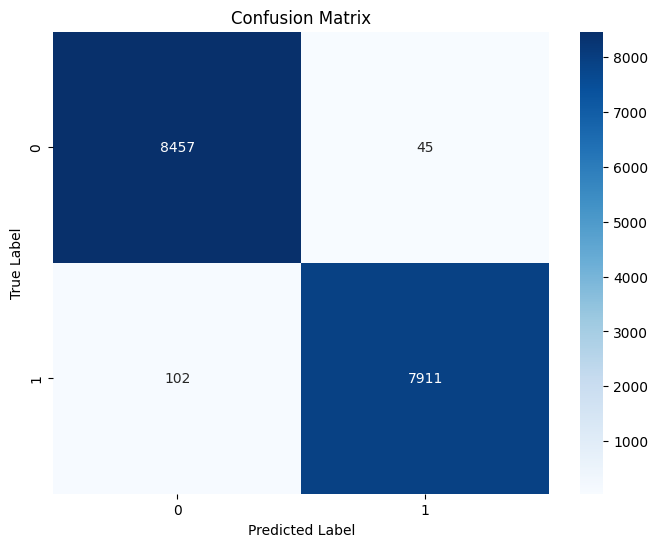

In [65]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")

# Predict probabilities
test_probabilities = model.predict(X_test)
# Convert probabilities to binary predictions (0 or 1)
test_predictions = (test_probabilities > 0.5).astype(int)

from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
# Fit the encoder with the original test labels to get the class names
encoder.fit(y_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, test_predictions)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Plot a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [66]:
model.save("V+A+T99.11%RESLSTM_dlib_mfcc_bert.h5")